### Upload the Log File  

In [ ]:
from google.colab import files

uploaded = files.upload()

Saving ecommerce_server_logs.txt to ecommerce_server_logs.txt


### Load and Parse Logs  

In [ ]:
import pandas as pd
import re

def load_logs(filepath):

    pattern = re.compile(
        r"^(\d{4}-\d{2}-\d{2} \d{2}:\d{2}:\d{2}) \[(INFO|WARN|ERROR)\] (\w+) (\S+) (\d{3}) (\d+)ms - (.+)$"
    )

    log_data = []

    with open(filepath, "r") as f:
        for line in f:
            match = pattern.match(line.strip())
            if match:
                timestamp, level, method, endpoint, status, response_time, message = match.groups()
                log_data.append({
                    "timestamp": pd.to_datetime(timestamp),
                    "level": level,
                    "method": method,
                    "endpoint": endpoint,
                    "status_code": int(status),
                    "response_time_ms": int(response_time),
                    "message": message
                })

    return pd.DataFrame(log_data)

,timestamp,level,method,endpoint,status_code,response_time_ms,message
0,2025-08-14 08:00:00,INFO,GET,/checkout,201,137,User login successful
1,2025-08-14 08:02:24,INFO,GET,/checkout,201,417,Cart updated
2,2025-08-14 08:04:48,INFO,DELETE,/checkout,200,370,Inventory updated
3,2025-08-14 08:07:12,INFO,GET,/products,204,1021,Cart updated
4,2025-08-14 08:09:36,INFO,DELETE,/cart,201,301,User profile updated


### Inspect the Data

In [ ]:
df = load_logs("ecommerce_server_logs.txt")

df.info()

display(df.head(10))

df["response_time_ms"].describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   timestamp         150 non-null    datetime64[ns]
 1   level             150 non-null    object        
 2   method            150 non-null    object        
 3   endpoint          150 non-null    object        
 4   status_code       150 non-null    int64         
 5   response_time_ms  150 non-null    int64         
 6   message           150 non-null    object        
dtypes: datetime64[ns](1), int64(2), object(4)
memory usage: 8.3+ KB


,timestamp,level,method,endpoint,status_code,response_time_ms,message
0,2025-08-14 08:00:00,INFO,GET,/checkout,201,137,User login successful
1,2025-08-14 08:02:24,INFO,GET,/checkout,201,417,Cart updated
2,2025-08-14 08:04:48,INFO,DELETE,/checkout,200,370,Inventory updated
3,2025-08-14 08:07:12,INFO,GET,/products,204,1021,Cart updated
4,2025-08-14 08:09:36,INFO,DELETE,/cart,201,301,User profile updated
5,2025-08-14 08:12:00,INFO,PUT,/users/321,204,864,Product details fetched
6,2025-08-14 08:14:24,INFO,PUT,/users/289,201,935,Product list retrieved
7,2025-08-14 08:16:48,INFO,DELETE,/products,201,1157,Inventory updated
8,2025-08-14 08:19:12,ERROR,DELETE,/cart,500,576,Unexpected server error
9,2025-08-14 08:21:36,INFO,DELETE,/cart,200,3025,Inventory updated


,response_time_ms
count,150.000000
mean,1174.433333
std,855.776224
min,62.000000
25%,549.250000
50%,1032.500000
75%,1559.250000
max,4975.000000


In [ ]:
import matplotlib.pyplot as plt

### Identify Slow Requests

In [ ]:
slow_requests = df[df["response_time_ms"] > 2000].copy()
slow_pct = len(slow_requests) / len(df) * 100
print(f"Slow requests count: {len(slow_requests)} ({slow_pct:.2f}%)")
display(slow_requests.head())

Slow requests count: 13 (8.67%)


,timestamp,level,method,endpoint,status_code,response_time_ms,message
9,2025-08-14 08:21:36,INFO,DELETE,/cart,200,3025,Inventory updated
10,2025-08-14 08:24:00,INFO,DELETE,/users/455,201,2838,Inventory updated
11,2025-08-14 08:26:24,WARN,DELETE,/checkout,400,3236,Missing required parameters
33,2025-08-14 09:19:12,WARN,POST,/users/371,404,2849,Rate limit exceeded
38,2025-08-14 09:31:12,WARN,DELETE,/checkout,404,3007,Rate limit exceeded


### Analyze Slow Requests by Endpoint  

In [ ]:
slow_by_endpoint = (
    slow_requests.groupby("endpoint")
    .size()
    .reset_index(name="count")
    .sort_values("count", ascending=False)
)
slow_by_endpoint["percent"] = slow_by_endpoint["count"] / len(slow_requests) * 100
display(slow_by_endpoint)

,endpoint,count,percent
1,/checkout,5,38.461538
0,/cart,2,15.384615
2,/products,2,15.384615
3,/users/279,1,7.692308
4,/users/334,1,7.692308
5,/users/371,1,7.692308
6,/users/455,1,7.692308


### Identify Slow Requests with Errors  

In [ ]:
slow_with_errors = slow_requests[slow_requests["level"] == "ERROR"].copy()
slow_errors_by_message = (
    slow_with_errors.groupby("message")
    .size()
    .reset_index(name="count")
    .sort_values("count", ascending=False)
)
display(slow_errors_by_message)

,message,count
0,Null pointer exception in checkout service,1
1,Payment processing error,1


### Calculate Average Response Time by Endpoint

In [30]:
avg_rt_by_endpoint = (
    df.groupby("endpoint")["response_time_ms"]
    .mean()
    .reset_index()
    .sort_values("response_time_ms", ascending=False)
)
display(avg_rt_by_endpoint.head(10))

,endpoint,response_time_ms
20,/users/279,3633.0
29,/users/334,2987.0
33,/users/371,2849.0
38,/users/455,2838.0
17,/users/25,1949.0
3,/users/100,1766.0
30,/users/340,1762.0
24,/users/306,1723.0
23,/users/30,1717.0
12,/users/180,1715.0


### Visualize Response Time Trends

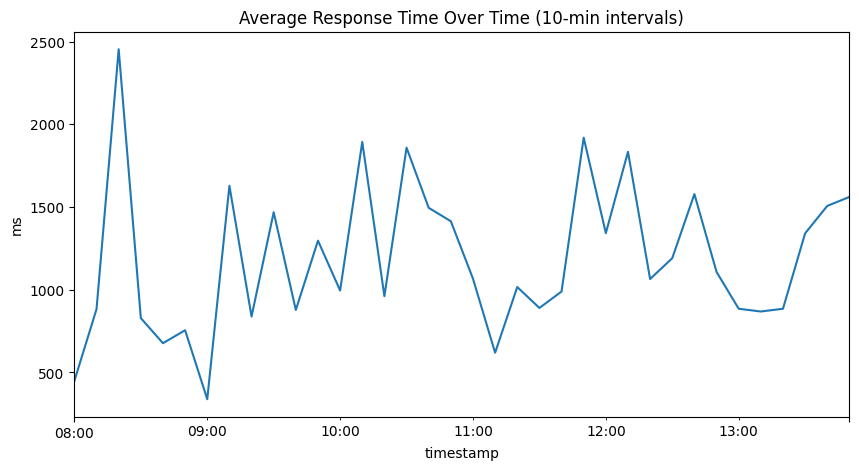

In [ ]:
df.set_index("timestamp")["response_time_ms"] \
  .resample("10min") \
  .mean() \
  .plot(figsize=(10, 5))
plt.title("Average Response Time Over Time (10-min intervals)")
plt.ylabel("ms")
plt.show()

### Extract and analyze error logs by message

In [ ]:
error_logs = df[df["level"] == "ERROR"].copy()
total_errors = len(error_logs)

error_by_message = (
    error_logs.groupby("message")
    .size()
    .reset_index(name="count")
    .sort_values("count", ascending=False)
)
error_by_message["percent"] = error_by_message["count"] / total_errors * 100
display(error_by_message)

print(f"\nTotal errors: {total_errors}")

,message,count,percent
3,Payment processing error,4,22.222222
6,Unexpected server error,4,22.222222
1,Failed to connect to DB,3,16.666667
2,Null pointer exception in checkout service,2,11.111111
0,Database connection timeout,2,11.111111
4,Service unavailable,2,11.111111
5,Timeout contacting payment gateway,1,5.555556



Total errors: 18


### Analyze errors by endpoint

In [ ]:
error_by_endpoint = (
    error_logs.groupby("endpoint")
    .size()
    .reset_index(name="count")
    .sort_values("count", ascending=False)
)
error_by_endpoint["percent"] = error_by_endpoint["count"] / total_errors * 100
display(error_by_endpoint)

,endpoint,count,percent
1,/checkout,6,33.333333
0,/cart,5,27.777778
2,/products,3,16.666667
3,/users/213,1,5.555556
4,/users/334,1,5.555556
5,/users/340,1,5.555556
6,/users/425,1,5.555556


### Analyze errors by HTTP status code

In [ ]:
error_by_status = (
    error_logs.groupby("status_code")
    .size()
    .reset_index(name="count")
    .sort_values("count", ascending=False)
)
error_by_status["percent"] = error_by_status["count"] / total_errors * 100
display(error_by_status)

,status_code,count,percent
0,500,6,33.333333
2,503,6,33.333333
1,502,4,22.222222
3,504,2,11.111111


### Plot error frequency over time

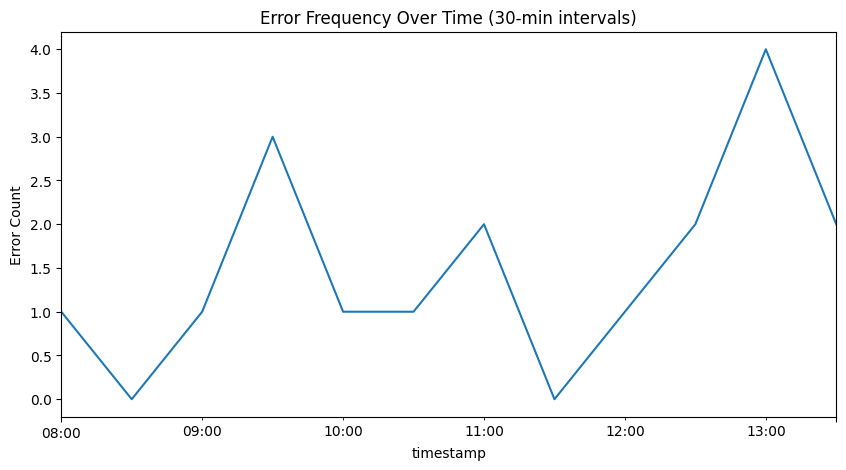

In [ ]:
error_logs.set_index("timestamp") \
    .resample("30min") \
    .size() \
    .plot(figsize=(10,5))
plt.title("Error Frequency Over Time (30-min intervals)")
plt.ylabel("Error Count")
plt.show()


## **Root Cause Analysis**

**Summary of Findings:**
The analysis of 150 log entries over a 6-hour period reveals two primary categories of performance degradation and failures:

1. **Checkout service instability linked to payment processing and application errors.**
2. **Product and cart operations impacted by database connectivity issues.**

---

### **1. Performance Analysis**

* **Slow Requests (>2000ms):**

  * Total: 13 slow requests (8.67% of all requests)
  * Most affected endpoints:

    * `/checkout` → 38.46% of slow requests
    * `/cart` and `/products` → each 15.38%
  * 15% of slow requests were also errors, primarily:

    * "Null pointer exception in checkout service" (1 occurrence)
    * "Payment processing error" (1 occurrence)

---

### **2. Error Analysis (All Errors)**

* **Total Errors:** 18 (12% of all requests)

* **Top Error Messages:**

  * *Payment processing error* → 22.22%
  * *Unexpected server error* → 22.22%
  * *Failed to connect to DB* → 16.67%
  * *Null pointer exception in checkout service* → 11.11%
  * *Database connection timeout* → 11.11%
  * *Service unavailable* → 11.11%
  * *Timeout contacting payment gateway* → 5.56%

* **Most Error-Prone Endpoints:**

  * `/checkout` → 33.33% of all errors
  * `/cart` → 27.78%
  * `/products` → 16.67%

* **Error Status Codes:**

  * 500 Internal Server Error → 33.33%
  * 503 Service Unavailable → 33.33%
  * 502 Bad Gateway → 22.22%
  * 504 Gateway Timeout → 11.11%

---

### **3. Time-Based Observations**

* Error spikes were observed around:

  * **09:30** (3 errors)
  * **13:00** (4 errors)
* These spikes correspond to clusters of `/checkout` and `/cart` failures.

---

### **4. Root Cause Conclusion**

1. **Checkout Failures:**

   * High error rate on `/checkout` (33.33%) with frequent *"Payment processing error"*, *"Null pointer exception"*, and *"Timeout contacting payment gateway"* indicates instability in the payment processing flow.
   * Likely causes:

     * Unhandled null values in checkout service code.
     * Latency or unavailability of the external payment gateway.

2. **Database-Related Failures:**

   * Errors such as *"Failed to connect to DB"* and *"Database connection timeout"* on `/products` and `/cart` suggest database connection pool exhaustion or temporary DB outages during traffic spikes.

3. **Overall System Impact:**

   * The payment gateway issue is likely an external dependency problem.
   * The database errors point to internal resource limits or infrastructure scaling issues.
   * Both are independent failure modes but together degrade the system’s performance and reliability.

## **Runbook – Troubleshooting Slow API Responses & Checkout Failures**

**Purpose:**  
Quick, repeatable steps to resolve performance degradation and failures in `/checkout`, `/cart`, and `/products` endpoints.

---

### **Trigger Conditions**

Start this runbook if more than 5% of requests exceed 2000ms, checkout error rate exceeds 5% in a 30-minute window, or multiple "Failed to connect to DB" or "Timeout contacting payment gateway" errors appear.

---

### **Investigation Steps + Tools**

#### **1. Check Application Logs**

Use grep, less, or centralized logging platforms like Datadog or ELK (Kibana) to search for recent error patterns and identify the root cause of failures. Focus on the last 100 error entries to understand current system behavior and pinpoint specific failure modes affecting the checkout process.

#### **2. Validate Payment Gateway Connectivity**

Test payment gateway responsiveness using curl, Postman, or monitoring tools like Pingdom to measure end-to-end latency and identify external service bottlenecks. If response times consistently exceed 2 seconds, escalate the issue directly to the payment provider for resolution.

#### **3. Assess Database Performance**

Examine database connection pools and active queries using psql, pgAdmin, or pg_stat_activity views to identify blocking queries or connection exhaustion. When the connection pool reaches capacity, terminate idle connections or increase pool limits to restore normal database operations.

#### **4. Monitor Infrastructure Health**

Analyze system resources using htop, iostat, Grafana dashboards, or AWS CloudWatch to evaluate CPU utilization, memory consumption, and network throughput. High resource usage often correlates with performance degradation and requires immediate attention to prevent service outages.

---

### **Remediation Actions**

Restart only the affected service to minimize downtime while preserving other system components. Enable retry logic and increase timeout values for payment API calls to handle temporary network issues. Implement caching mechanisms and configure read replicas for database queries to distribute load and improve response times.

---

### **Prevention**

Configure monitoring alerts using Grafana with Prometheus or AWS CloudWatch to proactively detect issues before they impact users. Set thresholds for checkout error rates above 5%, database pool usage exceeding 80%, and request latencies over 2000ms lasting more than 2 minutes. Implement circuit breaker patterns for payment gateway calls to prevent cascading failures during external service outages.